# Amalgame (Dataset3)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import gensim
import re
import spacy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping,ModelCheckpoint

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [4]:
import gensim
# load the AraVec model
model = gensim.models.Word2Vec.load("/content/drive/MyDrive/DataMem/full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.mdl")
print("We've",len(model.wv.index2word),"vocabularies")

We've 1476715 vocabularies


# Préparation données

In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
import nltk
#import nltk as nlp
import string
import re


In [6]:
df= pd.read_excel('/content/drive/MyDrive/DataMem/dataset3.xlsx')

In [7]:
df.Class.value_counts()

0    4195
1    2743
Name: Class, dtype: int64

In [8]:
!pip install  alphabet_detector 


  Created wheel for alphabet-detector: filename=alphabet_detector-0.0.7-cp37-none-any.whl size=2446 sha256=7b44693b55307226b667dad74f69802f0c955f23e589af1792a0d2d5a8c85dcf
  Stored in directory: /root/.cache/pip/wheels/75/a7/c3/faf515469622e565475fc96983418ba6e03f6a0f73755cd892
Successfully built alphabet-detector


In [9]:
# Pretraitement data
 
import re
import string
from alphabet_detector import AlphabetDetector
from bs4 import BeautifulSoup
#definition des diactrics
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

#Suppression des diactrics
def remove_diacritics(text):  #إزالة علامات التشكيل *
    text = re.sub(arabic_diacritics, '', text)
    return text

#Suppression de punctuations
def remove_punctuation(s): 
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»" + "!"
    translator = str.maketrans('', '', my_punctuations)
    return s.translate(translator)


def remove_punctuation2(s): # replace punctuation with space
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»"
    replace_table = str.maketrans(my_punctuations,  ' '*len(my_punctuations))
    return s.translate(replace_table)

#remove text change from html to text
def html2text(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()


#remove other letters
def remove_links(text):
 
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

# remove empty lines
def remove_empty_lines(text):
    lines = [s.rstrip() for s in text.split("\n") if s.rstrip()]
    return '\n'.join(lines)


def remove_repeating_char(text):
    # return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)  # keep 2 repeat

#remove any othe language letters
def keep_only_arabic(text):
    ad = AlphabetDetector()
    clean_lines = list()
    for line in text.splitlines():
        clean_line = list()
        for word in line.split():
            if len(word) > 1:
                if ad.is_arabic(word):
                    if word.isalpha():
                        clean_line.append(word)
        clean_lines.append(' '.join(clean_line))
    return '\n'.join(clean_lines)


def clean_doc(text):
    text = html2text(text)
  
    text = text.replace('\\', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    clean_text = remove_links(text)
    clean_text = remove_diacritics(clean_text)
    clean_text = remove_punctuation2(clean_text)
    clean_text = keep_only_arabic(clean_text)
    clean_text = remove_repeating_char(clean_text)
    clean_text = remove_empty_lines(clean_text)
    return clean_text


In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('arabic'))
df['Tweet'] = df['Tweet'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stopwords.words('arabic')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على'

In [11]:
#df['body'].values.tolist()
df['Tweet'] = df['Tweet'].astype(str).values
df['Tweet']=df['Tweet'].apply(clean_doc)
df['Tweet']=df['Tweet'].apply(clean_str)

In [12]:
df.Class.value_counts()

0    4195
1    2743
Name: Class, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
X = df['Tweet'].astype(str).values
y= df['Class'].values
   
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, shuffle=True)

In [14]:
max_num_words=len(X_train)
print(max_num_words)

5550


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
max_num_words =max_num_words
max_length =39

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_val)

X_tr = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
X_tes = pad_sequences(list_tokenized_test, maxlen=max_length, padding='post')


In [16]:
# Identify max length of reviews
max_length = 0
for review_number in range(len(list_tokenized_train)):
  numberofwords=len(list_tokenized_train [review_number])
  if (numberofwords) > (max_length):
    max_length = numberofwords
print(max_length)

39


In [17]:
# Show the vocabulory
word_index = tokenizer.word_index
print(tokenizer.word_index)
print('Found %s unique tokens.' % len(word_index))

{'جبران': 1, 'باسيل': 2, 'انت': 3, 'الله': 4, 'شو': 5, 'عم': 6, 'مش': 7, 'لبنان': 8, 'ان': 9, 'كان': 10, 'الي': 11, 'هوا': 12, 'وهاب': 13, 'كول': 14, 'الوزير': 15, 'واحد': 16, 'قطر': 17, 'شي': 18, 'يلي': 19, 'انو': 20, 'اذا': 21, 'مين': 22, 'كلب': 23, 'اللي': 24, 'هيك': 25, 'سوريا': 26, 'متل': 27, 'هه': 28, 'والله': 29, 'الرئيس': 30, 'وزير': 31, 'روح': 32, 'وئام': 33, 'اسرائيل': 34, 'انا': 35, 'حدا': 36, 'او': 37, 'بدك': 38, 'انك': 39, 'دوله': 40, 'يعني': 41, 'بلا': 42, 'هيدا': 43, 'حق': 44, 'ابو': 45, 'وانت': 46, 'عون': 47, 'قال': 48, 'لازم': 49, 'الا': 50, 'ابن': 51, 'قبل': 52, 'منك': 53, 'كنت': 54, 'انه': 55, 'عثمان': 56, 'رئيس': 57, 'القمه': 58, 'الناس': 59, 'ولك': 60, 'بدو': 61, 'رح': 62, 'الخارجيه': 63, 'العربيه': 64, 'كلاب': 65, 'الحريري': 66, 'الاسد': 67, 'وين': 68, 'الدوله': 69, 'علي': 70, 'بشار': 71, 'معالي': 72, 'الحق': 73, 'البلد': 74, 'ليش': 75, 'لان': 76, 'حالك': 77, 'اكيد': 78, 'حمار': 79, 'اي': 80, 'سعد': 81, 'السيد': 82, 'حزب': 83, 'تحكي': 84, 'يكون': 85, 'ايه': 86, 'ح

In [18]:
len(list_tokenized_train)

5550

In [19]:
X_tr.shape

(5550, 39)

In [20]:
model["الجزائر"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 7.03658164e-01, -1.17206454e+00,  5.20509899e-01,  1.79336345e+00,
       -8.71224701e-01, -7.36100554e-01,  4.82115835e-01, -1.24040973e+00,
       -1.07708979e+00,  1.25925314e+00, -1.83763373e+00,  4.54997092e-01,
       -8.53953481e-01,  3.38911712e-01, -1.61027372e+00, -1.09810233e+00,
       -5.55308238e-02,  6.90826774e-01,  5.31724334e-01,  1.81677234e+00,
        4.46090937e-01,  6.63624406e-01,  7.58774519e-01,  9.54323828e-01,
       -1.52540123e+00,  8.54157805e-01,  8.68102163e-03, -1.54378521e+00,
        1.43151319e+00,  4.97710705e-01, -3.91972452e-01,  9.24101293e-01,
        1.47198272e+00, -1.13544583e+00, -3.78376208e-02,  9.40275967e-01,
       -8.52677882e-01, -4.73342806e-01, -2.84870535e-01, -2.47993708e+00,
       -5.88883221e-01, -2.84091473e-01, -2.47201577e-01, -3.50306988e-01,
       -6.83169603e-01,  1.19394457e+00,  5.59217572e-01, -7.40278184e-01,
       -7.89027393e-01, -7.10870326e-01, -1.01076615e+00,  3.44163664e-02,
        2.05796242e+00,  

In [21]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300  
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
        embedding_vector = model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embeddings Matrix shape : ",embedding_matrix.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Embeddings Matrix shape :  (17895, 300)


In [22]:
from tensorflow.keras.layers import *
# create the embedding layer
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length)

In [23]:
from tensorflow.keras.layers import Embedding, LSTM,Conv1D,GlobalMaxPooling1D, MaxPooling1D,Dense,Bidirectional,Flatten## Neural networks layers 
from tensorflow.keras.models import Sequential

In [24]:
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
opt = RMSprop(lr=0.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# BiLSTM

In [56]:
model2=Sequential()
model2.add(embedding_layer ) 

model2.add(Bidirectional( LSTM(units=128,return_sequences=True)))

model2.add(Flatten())

model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.2))
#Output  Layer

model2.add(Dense(1, activation='sigmoid')) 
print(model2.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           5368500   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 39, 256)           439296    
_________________________________________________________________
flatten_6 (Flatten)          (None, 9984)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               998500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 6,806,397
Trainable params: 6,806,397
Non-trainable params: 0
____________________________________________

In [57]:
#model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('/content/training03.log', separator=',', append=False)
callbacks = [
 EarlyStopping(monitor='val_accuracy', mode='max',
                              patience=2, verbose=1),
#ModelCheckpoint(filepath = '/content/model_best_thebestt.h5', monitor='val_accuracy', mode='max',
                       #     verbose=1, save_best_only=True, save_weights_only = True),
        csv_logger
    ]


In [62]:

opt=Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=16,verbose=2,callbacks=callbacks)


Epoch 1/10
347/347 - 24s - loss: 0.0348 - accuracy: 0.9899 - val_loss: 2.8426 - val_accuracy: 0.8206
Epoch 2/10
347/347 - 19s - loss: 0.0171 - accuracy: 0.9906 - val_loss: 2.9594 - val_accuracy: 0.8393
Epoch 3/10
347/347 - 19s - loss: 0.0152 - accuracy: 0.9919 - val_loss: 3.2170 - val_accuracy: 0.8228
Epoch 4/10
347/347 - 19s - loss: 0.0148 - accuracy: 0.9919 - val_loss: 3.2420 - val_accuracy: 0.8343
Epoch 00004: early stopping


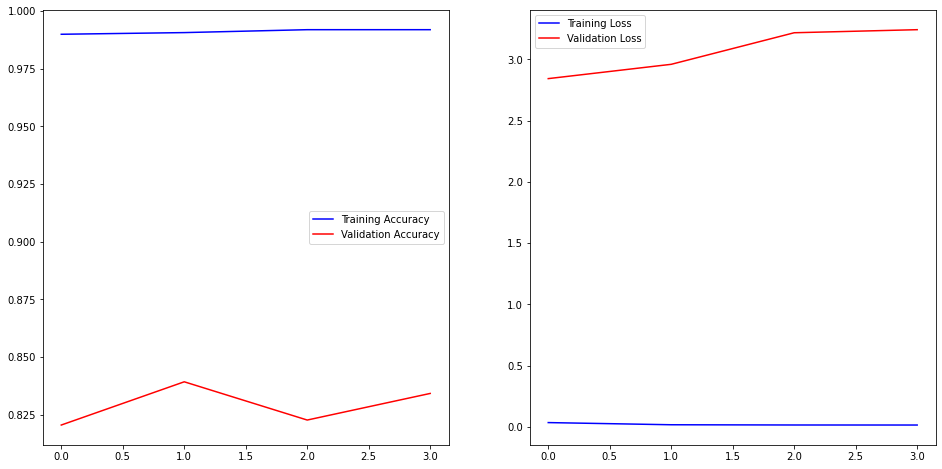

In [63]:
history = pd.read_csv('/content/training03.log', sep=',', engine='python')
hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']


x_min = 0
x_max = 2.0
f,ax=plt.subplots(1,2,figsize=(16,8))


ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [64]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))


			PERFORMANCE

Accuracy: 0.8343 

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       846
           1       0.80      0.76      0.78       542

    accuracy                           0.83      1388
   macro avg       0.83      0.82      0.82      1388
weighted avg       0.83      0.83      0.83      1388



In [65]:
model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=5,verbose=2)

Epoch 1/5
174/174 - 10s - loss: 0.0134 - accuracy: 0.9923 - val_loss: 3.2907 - val_accuracy: 0.8372
Epoch 2/5
174/174 - 10s - loss: 0.0131 - accuracy: 0.9921 - val_loss: 3.5047 - val_accuracy: 0.8300
Epoch 3/5
174/174 - 10s - loss: 0.0133 - accuracy: 0.9923 - val_loss: 3.4382 - val_accuracy: 0.8350
Epoch 4/5
174/174 - 10s - loss: 0.0140 - accuracy: 0.9919 - val_loss: 3.2291 - val_accuracy: 0.8242
Epoch 5/5
174/174 - 10s - loss: 0.0134 - accuracy: 0.9917 - val_loss: 3.4125 - val_accuracy: 0.8343


In [66]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))


			PERFORMANCE

Accuracy: 0.8343 

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       846
           1       0.79      0.78      0.79       542

    accuracy                           0.83      1388
   macro avg       0.83      0.83      0.83      1388
weighted avg       0.83      0.83      0.83      1388



# **Hybridation CNN_Bilstm** 

Param 250/3/0.3

In [52]:
        model3= Sequential()
        model3.add(embedding_layer ) 
        model3.add(Conv1D(128, 3,activation='relu',padding="valid", strides=1))
        
        model3.add(MaxPooling1D(pool_size=3))
        model3.add(Bidirectional(LSTM(units=128,return_sequences=True)))
        model3.add(Flatten())
        model3.add(Dense(128, activation='relu'))
        model3.add(Dropout(0.3))
        model3.add(Dense(1))
        model3.add(Activation('sigmoid'))
        

print(model3.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           5368500   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 37, 128)           115328    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 12, 256)           263168    
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               393344    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
#model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_7.h5')

In [53]:

opt=Adam(learning_rate=0.001)
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=64,verbose=2,callbacks=callbacks)


Epoch 1/10
87/87 - 9s - loss: 0.1096 - accuracy: 0.9564 - val_loss: 0.6782 - val_accuracy: 0.8293
Epoch 2/10
87/87 - 5s - loss: 0.0384 - accuracy: 0.9841 - val_loss: 0.8430 - val_accuracy: 0.8429
Epoch 3/10
87/87 - 5s - loss: 0.0278 - accuracy: 0.9890 - val_loss: 0.9334 - val_accuracy: 0.8357
Epoch 4/10
87/87 - 5s - loss: 0.0241 - accuracy: 0.9885 - val_loss: 1.1295 - val_accuracy: 0.8386
Epoch 00004: early stopping


In [54]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8386 

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       846
           1       0.80      0.78      0.79       542

    accuracy                           0.84      1388
   macro avg       0.83      0.83      0.83      1388
weighted avg       0.84      0.84      0.84      1388



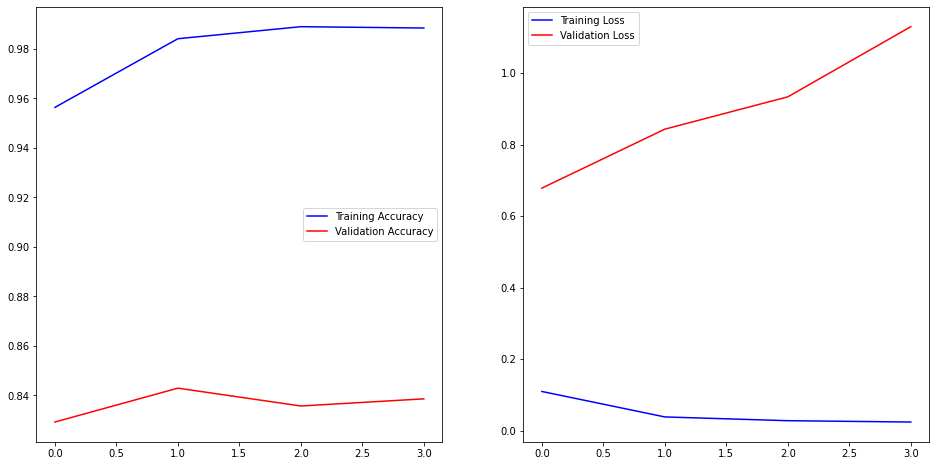

In [55]:


hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()


In [ ]:
#model2.save('/content/drive/MyDrive/DataMem/BiLSTM_emb40_Al_Jazeera.h5')

In [67]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#print(model3.summary())
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
174/174 [==============================] - 14s 65ms/step - loss: 0.0311 - accuracy: 0.9868 - val_loss: 0.9452 - val_accuracy: 0.8314
Epoch 2/100
174/174 [==============================] - 10s 59ms/step - loss: 0.0236 - accuracy: 0.9895 - val_loss: 1.0680 - val_accuracy: 0.8336
Epoch 3/100
174/174 [==============================] - 10s 59ms/step - loss: 0.0183 - accuracy: 0.9908 - val_loss: 1.3540 - val_accuracy: 0.8401
Epoch 4/100
174/174 [==============================] - 10s 59ms/step - loss: 0.0149 - accuracy: 0.9917 - val_loss: 1.5900 - val_accuracy: 0.8379
Epoch 5/100
174/174 [==============================] - 10s 60ms/step - loss: 0.0158 - accuracy: 0.9908 - val_loss: 1.5958 - val_accuracy: 0.8365
Epoch 6/100
174/174 [==============================] - 10s 60ms/step - loss: 0.0139 - accuracy: 0.9919 - val_loss: 1.8441 - val_accuracy: 0.8408
Epoch 7/100
174/174 [==============================] - 10s 60ms/step - loss: 0.0140 - accuracy: 0.9923 - val_loss: 1.7024 - val_ac

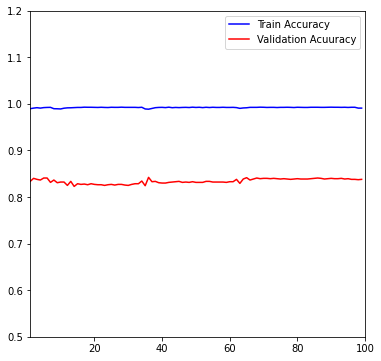

In [77]:
hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

fig, ax = plt.subplots(figsize=(6, 6))

x = np.arange(0, 10, 1)
y = acc
z = val_acc

ax.plot(y, color='blue', label='Train Accuracy')
ax.plot(z, color='red', label='Validation Acuuracy')
ax.legend()
plt.xlim([1, 100])
plt.ylim([0.5,1.2])
plt.show()

In [78]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8379 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       846
           1       0.81      0.76      0.79       542

    accuracy                           0.84      1388
   macro avg       0.83      0.82      0.83      1388
weighted avg       0.84      0.84      0.84      1388



Param 250/3/0.3


In [43]:
        model4= Sequential()
        model4.add(embedding_layer ) 
        model4.add(Conv1D(250,5,activation='relu',padding="valid", strides=1))
        
        model4.add(MaxPooling1D(pool_size=3))
        model4.add(Bidirectional(LSTM(units=250,return_sequences=True)))
        model4.add(Flatten())
        model4.add(Dense(250, activation='relu'))
        model4.add(Dropout(0.3))
        model4.add(Dense(1))
        model4.add(Activation('sigmoid'))

        print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           5368500   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 250)           375250    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 250)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 11, 500)           1002000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               1375250   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)              

In [44]:
 opt=Adam(learning_rate=0.001)       
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history=model4.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=20,batch_size=32)

Epoch 1/20
174/174 [==============================] - 15s 67ms/step - loss: 0.1872 - accuracy: 0.9337 - val_loss: 0.7313 - val_accuracy: 0.8422
Epoch 2/20
174/174 [==============================] - 11s 61ms/step - loss: 0.1050 - accuracy: 0.9643 - val_loss: 0.5535 - val_accuracy: 0.8271
Epoch 3/20
174/174 [==============================] - 11s 61ms/step - loss: 0.0688 - accuracy: 0.9744 - val_loss: 0.6023 - val_accuracy: 0.8264
Epoch 4/20
174/174 [==============================] - 11s 62ms/step - loss: 0.0465 - accuracy: 0.9805 - val_loss: 0.8363 - val_accuracy: 0.8329
Epoch 5/20
174/174 [==============================] - 11s 61ms/step - loss: 0.0393 - accuracy: 0.9836 - val_loss: 0.8986 - val_accuracy: 0.8256
Epoch 6/20
174/174 [==============================] - 11s 61ms/step - loss: 0.0304 - accuracy: 0.9870 - val_loss: 1.2422 - val_accuracy: 0.8379
Epoch 7/20
174/174 [==============================] - 11s 62ms/step - loss: 0.0268 - accuracy: 0.9888 - val_loss: 1.0707 - val_accuracy:

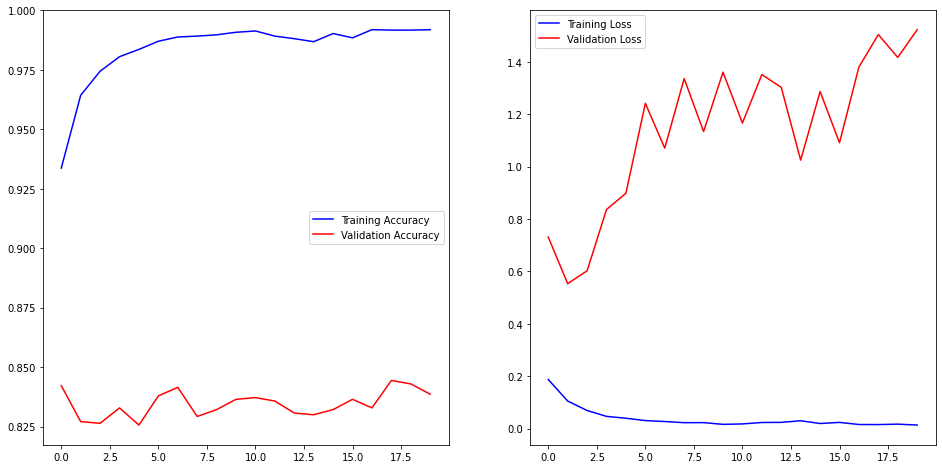

In [45]:


hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
#model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_3.h5')

In [46]:
y_test= model4.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8386 

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       846
           1       0.81      0.77      0.79       542

    accuracy                           0.84      1388
   macro avg       0.83      0.83      0.83      1388
weighted avg       0.84      0.84      0.84      1388



In [47]:

phrase1 = ['ابن كلب كان يردح على الحريات وقت الإخوان بس لما العسكر يقمعوا الحريات عادي']
phrase2=['دخل هالبسمة يا قاهرهم ',]

seq1= tokenizer.texts_to_sequences(phrase1)
seq2= tokenizer.texts_to_sequences(phrase2)
data1 = pad_sequences(seq1, maxlen= 39 , padding='post')
data2 = pad_sequences(seq2, maxlen= 39 , padding='post')

prediction1=model4.predict(data1)
prediction2=model4.predict(data2)
print('predection \n  1 : ',prediction1 , '\n 2: ',prediction2)


predection 
  1 :  [[1.]] 
 2:  [[6.7037156e-08]]
